<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/SRAG_2021_a_2023S1_openDataSUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRAG 2021 a 2023 - Banco de Dados de Síndrome Respiratória Aguda Grave

Dados atualizados até 22 de Fevereiro de 2023

https://opendatasus.saude.gov.br/dataset/srag-2021-a-2023

In [ ]:
# Instalar pt_BR
!/usr/share/locales/install-language-pack pt_BR
!dpkg-reconfigure locales

import os

# Reiniciar o Python
os.kill(os.getpid(), 9)

Generating locales (this might take a while)...
  pt_BR.ISO-8859-1... done
Generation complete.
dpkg-trigger: error: must be called from a maintainer script (or with a --by-package option)

Type dpkg-trigger --help for help about this utility.
Generating locales (this might take a while)...
  en_US.UTF-8... done
  pt_BR.ISO-8859-1... done
Generation complete.


# Importações

In [1]:
import numpy as np
import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

import datetime, locale

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

locale.setlocale(locale.LC_ALL, 'pt_BR')

SEMENTE  = 2001088 + 2001247 + 2003061 + 2008193 + 2008620 + 2008880

PALETA = 'summer_r'
CORES  = ['#008066', '#609F6C', '#A7C774', '#FFFF66']

SEXOS = {1: 'Masculino',
         2: 'Feminino'}

EVOLUCOES = {1: 'Cura',
             2: 'Óbito',
             3: 'Óbito por outras causas'}

DIAGNOSTICOS = {1: 'SRAG por Influenza',
                2: 'SRAG por outro vírus respiratório',
                3: 'SRAG por outro agente etiológico',
                4: 'SRAG não especificado',
                5: 'SRAG por COVID-19'}

# Dados

In [3]:
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/openDataSUS.7z.001
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/openDataSUS.7z.002
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/openDataSUS.7z.003
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/openDataSUS.7z.004

!7z e /content/openDataSUS.7z.001

--2023-03-01 14:07:05--  https://raw.githubusercontent.com/flohmannjr/PJI410/main/openDataSUS.7z.001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25165824 (24M) [application/octet-stream]
Saving to: ‘openDataSUS.7z.001’

openDataSUS.7z.001  100%[===================>]  24.00M  79.6MB/s    in 0.3s    

2023-03-01 14:07:07 (79.6 MB/s) - ‘openDataSUS.7z.001’ saved [25165824/25165824]

--2023-03-01 14:07:08--  https://raw.githubusercontent.com/flohmannjr/PJI410/main/openDataSUS.7z.002
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [4]:
dtypes = {'DT_NOTIFIC': 'string', 'SEM_NOT': 'Int32', 'DT_SIN_PRI': 'string', 'SEM_PRI': 'Int32', 'SG_UF_NOT': 'string', 'ID_REGIONA': 'string', 'CO_REGIONA': 'Int32',
          'ID_MUNICIP': 'string', 'CO_MUN_NOT': 'Int32', 'ID_UNIDADE': 'string', 'CO_UNI_NOT': 'Int32', 'CS_SEXO': 'string', 'DT_NASC': 'string', 'NU_IDADE_N': 'Int32',
          'TP_IDADE': 'Int32', 'COD_IDADE': 'string', 'CS_GESTANT': 'Int32', 'CS_RACA': 'Int32', 'CS_ESCOL_N': 'Int32', 'ID_PAIS': 'string', 'CO_PAIS': 'Int32',
          'SG_UF': 'string', 'ID_RG_RESI': 'string', 'CO_RG_RESI': 'Int32', 'ID_MN_RESI': 'string', 'CO_MUN_RES': 'Int32', 'CS_ZONA': 'Int32', 'SURTO_SG': 'string',
          'NOSOCOMIAL': 'Int32', 'AVE_SUINO': 'Int32', 'FEBRE': 'Int32', 'TOSSE': 'Int32', 'GARGANTA': 'Int32', 'DISPNEIA': 'Int32', 'DESC_RESP': 'Int32', 'SATURACAO': 'Int32',
          'DIARREIA': 'Int32', 'VOMITO': 'Int32', 'OUTRO_SIN': 'Int32', 'OUTRO_DES': 'string', 'PUERPERA': 'Int32', 'FATOR_RISC': 'Int32', 'CARDIOPATI': 'Int32',
          'HEMATOLOGI': 'Int32', 'SIND_DOWN': 'Int32', 'HEPATICA': 'Int32', 'ASMA': 'Int32', 'DIABETES': 'Int32', 'NEUROLOGIC': 'Int32', 'PNEUMOPATI': 'Int32',
          'IMUNODEPRE': 'Int32', 'RENAL': 'Int32', 'OBESIDADE': 'Int32', 'OBES_IMC': 'string', 'OUT_MORBI': 'Int32', 'MORB_DESC': 'string', 'VACINA': 'Int32',
          'DT_UT_DOSE': 'string', 'MAE_VAC': 'Int32', 'DT_VAC_MAE': 'string', 'M_AMAMENTA': 'Int32', 'DT_DOSEUNI': 'string', 'DT_1_DOSE': 'string', 'DT_2_DOSE': 'string',
          'ANTIVIRAL': 'Int32', 'TP_ANTIVIR': 'Int32', 'OUT_ANTIV': 'string', 'DT_ANTIVIR': 'string', 'HOSPITAL': 'Int32', 'DT_INTERNA': 'string', 'SG_UF_INTE': 'string',
          'ID_RG_INTE': 'string', 'CO_RG_INTE': 'Int32', 'ID_MN_INTE': 'string', 'CO_MU_INTE': 'Int32', 'UTI': 'Int32', 'DT_ENTUTI': 'string', 'DT_SAIDUTI': 'string',
          'SUPORT_VEN': 'Int32', 'RAIOX_RES': 'Int32', 'RAIOX_OUT': 'string', 'DT_RAIOX': 'string', 'AMOSTRA': 'Int32', 'DT_COLETA': 'string', 'TP_AMOSTRA': 'Int32',
          'OUT_AMOST': 'string', 'PCR_RESUL': 'Int32', 'DT_PCR': 'string', 'POS_PCRFLU': 'Int32', 'TP_FLU_PCR': 'Int32', 'PCR_FLUASU': 'Int32', 'FLUASU_OUT': 'string',
          'PCR_FLUBLI': 'Int32', 'FLUBLI_OUT': 'string', 'POS_PCROUT': 'Int32', 'PCR_VSR': 'Int32', 'PCR_PARA1': 'Int32', 'PCR_PARA2': 'Int32', 'PCR_PARA3': 'Int32',
          'PCR_PARA4': 'Int32', 'PCR_ADENO': 'Int32', 'PCR_METAP': 'Int32', 'PCR_BOCA': 'Int32', 'PCR_RINO': 'Int32', 'PCR_OUTRO': 'Int32', 'DS_PCR_OUT': 'string',
          'CLASSI_FIN': 'Int32', 'CLASSI_OUT': 'string', 'CRITERIO': 'Int32', 'EVOLUCAO': 'Int32', 'DT_EVOLUCA': 'string', 'DT_ENCERRA': 'string', 'DT_DIGITA': 'string',
          'HISTO_VGM': 'string', 'PAIS_VGM': 'string', 'CO_PS_VGM': 'string', 'LO_PS_VGM': 'string', 'DT_VGM': 'string', 'DT_RT_VGM': 'string', 'PCR_SARS2': 'Int32',
          'PAC_COCBO': 'string', 'PAC_DSCBO': 'string', 'OUT_ANIM': 'string', 'DOR_ABD': 'Int32', 'FADIGA': 'Int32', 'PERD_OLFT': 'Int32', 'PERD_PALA': 'Int32',
          'TOMO_RES': 'Int32', 'TOMO_OUT': 'string', 'DT_TOMO': 'string', 'TP_TES_AN': 'Int32', 'DT_RES_AN': 'string', 'RES_AN': 'Int32', 'POS_AN_FLU': 'Int32',
          'TP_FLU_AN': 'Int32', 'POS_AN_OUT': 'Int32', 'AN_SARS2': 'Int32', 'AN_VSR': 'Int32', 'AN_PARA1': 'Int32', 'AN_PARA2': 'Int32', 'AN_PARA3': 'Int32',
          'AN_ADENO': 'Int32', 'AN_OUTRO': 'Int32', 'DS_AN_OUT': 'string', 'TP_AM_SOR': 'Int32', 'SOR_OUT': 'string', 'DT_CO_SOR': 'string', 'TP_SOR': 'Int32',
          'OUT_SOR': 'string', 'DT_RES': 'string', 'RES_IGG': 'Int32', 'RES_IGM': 'Int32', 'RES_IGA': 'Int32', 'ESTRANG': 'Int32', 'VACINA_COV': 'Int32',
          'DOSE_1_COV': 'string', 'DOSE_2_COV': 'string', 'DOSE_REF': 'string', 'FAB_COV_1': 'string', 'FAB_COV_2': 'string', 'FAB_COVREF': 'string', 'LAB_PR_COV': 'string',
          'LOTE_1_COV': 'string', 'LOTE_2_COV': 'string', 'LOTE_REF': 'string', 'FNT_IN_COV': 'Int32', 'DOSE_2REF': 'string', 'FAB_COVRF2': 'string', 'LOTE_REF2': 'string',
          'TRAT_COV': 'Int32', 'TIPO_TRAT': 'Int32', 'OUT_TRAT': 'string', 'DT_TRT_COV': 'string'}

# ausentes = df_23.columns[~df_23.columns.isin(df_21.columns)]
ausentes = ['DOSE_2REF', 'FAB_COVRF2', 'LOTE_REF2', 'TRAT_COV', 'TIPO_TRAT', 'OUT_TRAT', 'DT_TRT_COV']

datas = ['DT_NOTIFIC', 'DT_SIN_PRI', 'DT_NASC', 'DT_UT_DOSE', 'DT_VAC_MAE', 'DT_DOSEUNI', 'DT_1_DOSE', 'DT_2_DOSE', 'DT_ANTIVIR', 'DT_INTERNA',
         'DT_ENTUTI', 'DT_SAIDUTI', 'DT_RAIOX', 'DT_COLETA', 'DT_PCR', 'DT_EVOLUCA', 'DT_ENCERRA', 'DT_DIGITA', 'DT_VGM', 'DT_RT_VGM', 'DT_TOMO',
         'DT_RES_AN', 'DT_CO_SOR', 'DT_RES', 'DOSE_1_COV', 'DOSE_2_COV', 'DOSE_REF', 'DOSE_2REF', 'DT_TRT_COV']

In [5]:
%%time

df = pd.read_csv('INFLUD21-20-02-2023.csv', sep=';', dtype=dict(list(dtypes.items())[:-7]))

CPU times: user 1min 48s, sys: 9.53 s, total: 1min 58s
Wall time: 1min 59s


In [6]:
df[ausentes] = [None] * len(ausentes)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [7]:
%%time

df = pd.concat([df, pd.read_csv('INFLUD22-13-02-2023.csv', sep=';', dtype=dtypes)])
df = pd.concat([df, pd.read_csv('INFLUD23-13-02-2023.csv', sep=';', dtype=dtypes)])

CPU times: user 2min 1s, sys: 3.62 s, total: 2min 5s
Wall time: 2min 12s


In [8]:
%%time

for campo in datas:
    df[campo] = pd.to_datetime(df[campo], format='%d/%m/%Y', errors='coerce')

CPU times: user 42.2 s, sys: 407 ms, total: 42.6 s
Wall time: 56.5 s


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Columns: 173 entries, DT_NOTIFIC to DT_TRT_COV
dtypes: Int32(99), datetime64[ns](29), string(45)
memory usage: 2.4 GB


## População estimada em 2021

https://www.ibge.gov.br/cidades-e-estados

In [10]:
df_populacao = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/populacao_estimada_2021.csv')

In [11]:
df_populacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   UF         27 non-null     object
 1   Nome       27 non-null     object
 2   Populacao  27 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 776.0+ bytes


## Pré-processamento

### Contagem

In [12]:
# Campos descritos no dicionário de dados.

dicionario = ['NU_NOTIFIC', 'DT_NOTIFIC', 'SEM_NOT', 'DT_SIN_PRI', 'SEM_PRI', 'SG_UF_NOT', 'ID_MUNICIP', 'CO_MUN_NOT', 'ID_REGIONA', 'CO_REGIONA', 'ID_UNIDADE',
              'CO_UNI_NOT', 'TEM_CPF', 'NU_CPF', 'ESTRANG', 'NU_CNS', 'NM_PACIENT', 'CS_SEXO', 'DT_NASC', 'NU_IDADE_N', 'TP_IDADE', 'CS_GESTANT', 'CS_RACA',
              'CS_ETINIA', 'POV_CT', 'TP_POV_CT', 'CS_ESCOL_N', 'PAC_COCBO', 'PAC_DSCBO', 'NM_MAE_PAC', 'NU_CEP', 'SG_UF', 'ID_RG_RESI', 'CO_RG_RESI',
              'ID_MN_RESI', 'CO_MUN_RES', 'NM_BAIRRO', 'NM_LOGRADO', 'NU_NUMERO', 'NM_COMPLEM', 'NU_DDD_TEL', 'NU_TELEFON', 'CS_ZONA', 'ID_PAIS', 'CO_PAIS',
              'NOSOCOMIAL', 'AVE_SUINO', 'OUT_ANIM', 'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'DOR_ABD',
              'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'OUTRO_SIN', 'OUTRO_DES', 'FATOR_RISC', 'PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA',
              'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OBES_IMC', 'OUT_MORBI', 'MORB_DESC', 'VACINA_COV',
              'DOSE_1_COV', 'DOSE_2_COV', 'DOSE_REF', 'DOSE_2REF', 'FAB_COV1', 'FAB_COV2', 'FAB_COVRF', 'FAB_COVRF2', 'LOTE_1_COV', 'LOTE_2_COV', 'LOTE_REF',
              'LOTE_REF2', 'FNT_IN_COV', 'VACINA', 'DT_UT_DOSE', 'MAE_VAC', 'DT_VAC_MAE', 'M_AMAMENTA', 'DT_DOSEUNI', 'DT_1_DOSE', 'DT_2_DOSE', 'ANTIVIRAL',
              'TP_ANTIVIR', 'OUT_ANTIV', 'DT_ANTIVIR', 'TRAT_COV', 'TIPO_TRAT', 'OUT_TRAT', 'DT_TRT_COV', 'HOSPITAL', 'DT_INTERNA', 'SG_UF_INTE', 'ID_RG_INTE',
              'CO_RG_INTE', 'ID_MN_INTE', 'CO_MU_INTE', 'ID_UN_INTE', 'CO_UN_INTE', 'UTI', 'DT_ENTUTI', 'DT_SAIDUTI', 'SUPORT_VEN', 'RAIOX_RES', 'RAIOX_OUT',
              'DT_RAIOX', 'TOMO_RES', 'TOMO_OUT', 'DT_TOMO', 'AMOSTRA', 'DT_COLETA', 'TP_AMOSTRA', 'OUT_AMOST', 'REQUI_GAL', 'TP_TES_AN', 'DT_RES_AN', 'RES_AN',
              'LAB_AN', 'CO_LAB_AN', 'POS_AN_FLU', 'TP_FLU_AN', 'POS_AN_OUT', 'AN_SARS2', 'AN_VSR', 'AN_PARA1', 'AN_PARA2', 'AN_PARA3', 'AN_ADENO', 'AN_OUTRO',
              'DS_AN_OUT', 'PCR_RESUL', 'DT_PCR', 'POS_PCRFLU', 'TP_FLU_PCR', 'PCR_FLUASU', 'FLUASU_OUT', 'PCR_FLUBLI', 'FLUBLI_OUT', 'POS_PCROUT',
              'PCR_SARS2', 'PCR_VSR', 'PCR_PARA1', 'PCR_PARA2', 'PCR_PARA3', 'PCR_PARA4', 'PCR_ADENO', 'PCR_METAP', 'PCR_BOCA', 'PCR_RINO', 'PCR_OUTRO',
              'DS_PCR_OUT', 'LAB_PCR', 'CO_LAB_PCR', 'TP_AM_SOR', 'SOR_OUT', 'DT_CO_SOR', 'TP_SOR', 'OUT_SOR', 'SOR_OUT', 'RES_IGG', 'RES_IGM', 'RES_IGA',
              'DT_RES', 'CLASSI_FIN', 'CLASSI_OUT', 'CRITERIO', 'EVOLUCAO', 'DT_EVOLUCA', 'DT_ENCERRA', 'NU_DO', 'OBSERVA', 'NOME_PROF', 'REG_PROF', 'DT_DIGITA']

In [13]:
# # Campos descritos no dicionário de dados, mas inexistentes nas fontes.
# # 'FAB_COV_1', 'FAB_COV_2', 'FAB_COVREF' (nas fontes) = 'FAB_COV1', 'FAB_COV2', 'FAB_COVRF' (no dicionário)

# inexistentes_csv = list(dicionario - dtypes.keys())

# inexistentes_csv

In [14]:
# Campos sem entrada no dicionário.
# 'FAB_COV_1', 'FAB_COV_2', 'FAB_COVREF' (nas fontes) = 'FAB_COV1', 'FAB_COV2', 'FAB_COVRF' (no dicionário)

inexistentes_dic = list((dtypes.keys() - dicionario) - set(['FAB_COV_1', 'FAB_COV_2', 'FAB_COVREF']))

# df[inexistentes_dic].info(show_counts=True)

In [15]:
# Campos de notificação e primeiros sintomas.

campos = ['DT_NOTIFIC', 'SEM_NOT', 'SG_UF_NOT', 'DT_SIN_PRI', 'SEM_PRI']

df[campos].info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   DT_NOTIFIC  2310360 non-null  datetime64[ns]
 1   SEM_NOT     2310360 non-null  Int32         
 2   SG_UF_NOT   2310360 non-null  string        
 3   DT_SIN_PRI  2310360 non-null  datetime64[ns]
 4   SEM_PRI     2310360 non-null  Int32         
dtypes: Int32(2), datetime64[ns](2), string(1)
memory usage: 92.5 MB


In [16]:
# Campos relativos a internação.

campos = ['HOSPITAL', 'DT_INTERNA', 'SG_UF_INTE', 'ID_RG_INTE', 'CO_RG_INTE', 'ID_MN_INTE', 'CO_MU_INTE']

df[campos].info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   HOSPITAL    2245036 non-null  Int32         
 1   DT_INTERNA  2157993 non-null  datetime64[ns]
 2   SG_UF_INTE  2239369 non-null  string        
 3   ID_RG_INTE  1800956 non-null  string        
 4   CO_RG_INTE  1800956 non-null  Int32         
 5   ID_MN_INTE  2163407 non-null  string        
 6   CO_MU_INTE  2163407 non-null  Int32         
dtypes: Int32(3), datetime64[ns](1), string(3)
memory usage: 121.2 MB


In [17]:
# Campos relativos à vacina contra COVID-19.

campos = ['FAB_COV_1', 'LOTE_1_COV', 'FAB_COV_2', 'LOTE_2_COV', 'FAB_COVREF', 'LOTE_REF', 'FAB_COVRF2', 'LOTE_REF2']

df[campos].info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   FAB_COV_1   685394 non-null  string
 1   LOTE_1_COV  590153 non-null  string
 2   FAB_COV_2   308176 non-null  string
 3   LOTE_2_COV  493157 non-null  string
 4   FAB_COVREF  193697 non-null  string
 5   LOTE_REF    192595 non-null  string
 6   FAB_COVRF2  33122 non-null   string
 7   LOTE_REF2   33170 non-null   string
dtypes: string(8)
memory usage: 158.6 MB


In [18]:
# Campos "marcado pelo usuário" ou vazio.

NAN0 = ['AN_ADENO', 'AN_OUTRO', 'AN_PARA1', 'AN_PARA2', 'AN_PARA3', 'AN_SARS2', 'AN_VSR', 'PCR_ADENO', 'PCR_BOCA', 'PCR_METAP',
        'PCR_OUTRO', 'PCR_PARA1', 'PCR_PARA2', 'PCR_PARA3', 'PCR_PARA4', 'PCR_RINO', 'PCR_SARS2', 'PCR_VSR']

df[NAN0].info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   AN_ADENO   166 non-null     Int32
 1   AN_OUTRO   1429 non-null    Int32
 2   AN_PARA1   72 non-null      Int32
 3   AN_PARA2   23 non-null      Int32
 4   AN_PARA3   157 non-null     Int32
 5   AN_SARS2   330875 non-null  Int32
 6   AN_VSR     6953 non-null    Int32
 7   PCR_ADENO  4630 non-null    Int32
 8   PCR_BOCA   2038 non-null    Int32
 9   PCR_METAP  2743 non-null    Int32
 10  PCR_OUTRO  2382 non-null    Int32
 11  PCR_PARA1  549 non-null     Int32
 12  PCR_PARA2  261 non-null     Int32
 13  PCR_PARA3  1877 non-null    Int32
 14  PCR_PARA4  597 non-null     Int32
 15  PCR_RINO   13955 non-null   Int32
 16  PCR_SARS2  798935 non-null  Int32
 17  PCR_VSR    28086 non-null   Int32
dtypes: Int32(18)
memory usage: 215.9 MB


In [19]:
# Campos relativos a origem e país.

campos = ['ESTRANG', 'ID_PAIS', 'CO_PAIS']

display(df[campos].info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   ESTRANG  1798643 non-null  Int32 
 1   ID_PAIS  2310360 non-null  string
 2   CO_PAIS  2310360 non-null  Int32 
dtypes: Int32(2), string(1)
memory usage: 57.3 MB


None

In [20]:
# Campos tipo 'Outro'.

outros = ['OUT_ANIM', 'OUTRO_DES', 'MORB_DESC', 'OUT_ANTIV', 'OUT_TRAT', 'RAIOX_OUT', 'TOMO_OUT', 'OUT_AMOST',
          'DS_AN_OUT', 'FLUASU_OUT', 'FLUBLI_OUT', 'DS_PCR_OUT', 'SOR_OUT', 'OUT_SOR', 'CLASSI_OUT']

# df[outros].info(show_counts=True)

In [21]:
# "Resultado da Sorologia para SARS-CoV-2." ???

sorologia = ['RES_IGG', 'RES_IGM', 'RES_IGA']

display(df[sorologia].info(show_counts=True))
# print()

# for campo in sorologia:
#     display(df[campo].value_counts(dropna=False).sort_index())
#     print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   RES_IGG  256592 non-null  Int32
 1   RES_IGM  259464 non-null  Int32
 2   RES_IGA  202793 non-null  Int32
dtypes: Int32(3)
memory usage: 50.7 MB


None

In [22]:
# Quantidade de registros com sexo diferente de Masculino ou Feminino.

(~df['CS_SEXO'].isin(['M', 'F'])).sum()

376

In [23]:
# Quantidade de registros sem data de nascimento.

df['DT_NASC'].isna().sum()

1390

In [24]:
# Quantidade de registros sem unidade federativa.

df['SG_UF'].isna().sum()

398

In [25]:
# # Quantidade de registros com ano de nascimento inferior a 1923, por ano.

# with pd.option_context('display.max_rows', None): 
#     display(df['DT_NASC'][df['DT_NASC'].dt.year < 1923].dt.year.value_counts().sort_index())

In [26]:
# Quantidade total de registros com ano de nascimento inferior a 1923.

(df['DT_NASC'].dt.year < 1923).sum()

6137

In [27]:
# Quantidade de registros com unidade federativa onde está localizada a unidade que realizou a notificação diferente da internação do paciente.

df['SG_UF_NOT'][df['SG_UF_NOT'] != df['SG_UF_INTE']].count()

504

In [28]:
# Quantidade de registros com regional de saúde onde está localizada a unidade que realizou a notificação diferente da internação do paciente.

df['CO_REGIONA'][df['CO_REGIONA'] != df['CO_RG_INTE']].count()

4014

In [29]:
# Quantidade de registros com município onde está localizada a unidade que realizou a notificação diferente da internação do paciente.

df['CO_MUN_NOT'][df['CO_MUN_NOT'] != df['CO_MU_INTE']].count()

15126

### Correção

In [30]:
# Campos "marcado pelo usuário" com valores NaN para 0.
for campo in NAN0:
    df[campo].fillna(0, inplace=True)

# Campo CLASSI_FIN com valores NaN para 4-SRAG não especificado
df['CLASSI_FIN'].fillna(4, inplace=True)

# Campo CS_SEXO para numérico, como dicionário de dados.
df['CS_SEXO'].replace({'M': 1, 'F': 2, 'I': 9}, inplace=True)
df['CS_SEXO'] = df['CS_SEXO'].astype('Int32')

# Campos com valores NaN para 9-Ignorado.
NAN9 = ['AMOSTRA', 'ANTIVIRAL', 'ASMA', 'AVE_SUINO', 'CARDIOPATI', 'CRITERIO', 'CS_ESCOL_N', 'CS_RACA', 'CS_ZONA', 'DESC_RESP', 'DIABETES',
        'DIARREIA', 'DISPNEIA', 'DOR_ABD', 'EVOLUCAO', 'FADIGA', 'FATOR_RISC', 'FEBRE', 'FNT_IN_COV', 'GARGANTA', 'HEMATOLOGI', 'HEPATICA',
        'HOSPITAL', 'IMUNODEPRE', 'MAE_VAC', 'M_AMAMENTA', 'NEUROLOGIC', 'NOSOCOMIAL', 'OBESIDADE', 'OUTRO_SIN', 'OUT_MORBI', 'PCR_FLUASU',
        'PCR_FLUBLI', 'PCR_RESUL', 'PERD_OLFT', 'PERD_PALA', 'PNEUMOPATI', 'POS_AN_FLU', 'POS_AN_OUT', 'POS_PCRFLU', 'POS_PCROUT', 'PUERPERA',
        'RAIOX_RES', 'RENAL', 'RES_AN', 'SATURACAO', 'SIND_DOWN', 'SUPORT_VEN', 'TIPO_TRAT', 'TOMO_RES', 'TOSSE', 'TP_AMOSTRA', 'TP_AM_SOR',
        'TP_ANTIVIR', 'TP_FLU_AN', 'TP_FLU_PCR', 'TP_SOR', 'TP_TES_AN', 'TRAT_COV', 'UTI', 'VACINA', 'VACINA_COV', 'VOMITO']

for campo in NAN9:
    df[campo].fillna(9, inplace=True)

# Campo OBES_IMC para decimal.
df['OBES_IMC'][df['OBES_IMC'].str.contains(',', regex=False)] = df['OBES_IMC'][df['OBES_IMC'].str.contains(',', regex=False)].str.replace(',', '.')
df['OBES_IMC'] = df['OBES_IMC'].astype('Float32')

# Campos PAC_COCBO com valores 'XXX' para None.
df['PAC_COCBO'].replace({'XXX': None}, inplace=True)

# Campos PAC_DSCBO com valores 'NAO INFORMADO' para None.
df['PAC_DSCBO'].replace({'NAO INFORMADO': None}, inplace=True)

### Desmembramento

In [31]:
# DataFrame de ocupações, com códigos e descrições.

ocupacoes = ['PAC_COCBO', 'PAC_DSCBO']

df_ocupacoes = df[ocupacoes][~df[ocupacoes].duplicated()].dropna().sort_values(by='PAC_COCBO').reset_index(drop=True)

In [32]:
# DataFrame de unidades, com códigos e descrições.

unidades = ['CO_UNI_NOT', 'ID_UNIDADE']

df_unidades = df[unidades][~df[unidades].duplicated()].dropna().sort_values(by='CO_UNI_NOT').reset_index(drop=True)

In [33]:
# DataFrame de municípios, com códigos e descrições.

df_municipios = pd.concat([df[['CO_MUN_NOT', 'ID_MUNICIP']].set_axis(['CO_MUNICIP', 'ID_MUNICIP'], axis=1),
                           df[['CO_MUN_RES', 'ID_MN_RESI']].set_axis(['CO_MUNICIP', 'ID_MUNICIP'], axis=1),
                           df[['CO_MU_INTE', 'ID_MN_INTE']].set_axis(['CO_MUNICIP', 'ID_MUNICIP'], axis=1)])

df_municipios = df_municipios[~df_municipios.duplicated()].dropna().sort_values(by='CO_MUNICIP').reset_index(drop=True)

In [34]:
# DataFrame de regionais, com códigos e descrições.

df_regionais = pd.concat([df[['CO_REGIONA', 'ID_REGIONA']],
                          df[['CO_RG_RESI', 'ID_RG_RESI']].set_axis(['CO_REGIONA', 'ID_REGIONA'], axis=1),
                          df[['CO_RG_INTE', 'ID_RG_INTE']].set_axis(['CO_REGIONA', 'ID_REGIONA'], axis=1)])

df_regionais = df_regionais[~df_regionais.duplicated()].dropna().sort_values(by='CO_REGIONA').reset_index(drop=True)

### Limpeza

In [35]:
# Remover registros com sexo diferente de 1-Masculino ou 2-Feminino.
df.drop(df[~df['CS_SEXO'].isin([1, 2])].index, inplace=True)

# Remover registros sem data de nascimento ou unidade federativa.
df.dropna(subset=['DT_NASC', 'SG_UF'], inplace=True)

# Remover registros com ano de nascimento inferior a 1923.
df.drop(df[df['DT_NASC'].dt.year < 1923].index, inplace=True)

# Remover registros de pacientes estrangeiros.
df.drop(df[df['ESTRANG'] == 1].index, inplace=True)

# Remover campos vazios.
df.dropna(how='all', axis=1, inplace=True)

# Remover campos relativos à idade. (Temos a data de nascimento.)
df.drop(['NU_IDADE_N', 'TP_IDADE'], axis=1, inplace=True)

# Remover campos relativos ao país de origem. (Ao remover registros de pacientes estrangeiros ou sem unidade federativa, ficamos com apenas um valor nestes campos.)
df.drop(['ESTRANG', 'ID_PAIS', 'CO_PAIS'], axis=1, inplace=True)

# Remover campos de descrição dos dados desmembrados.
df.drop(['PAC_DSCBO', 'ID_UNIDADE', 'ID_MUNICIP', 'ID_MN_RESI', 'ID_MN_INTE', 'ID_REGIONA', 'ID_RG_RESI', 'ID_RG_INTE'], axis=1, inplace=True)

# Remover campos sem entrada no dicionário.
df.drop(inexistentes_dic, axis=1, inplace=True)

# Remover campos sobre resultado da sorologia para SARS-CoV-2. (O dicionário não contém a descrição dos valores.)
df.drop(sorologia, axis=1, inplace=True)

# Remover campos tipo 'Outro'. (Sem utilidade para macro-análises.)
df.drop(outros, axis=1, inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2277840 entries, 0 to 22642
Columns: 132 entries, DT_NOTIFIC to TIPO_TRAT
dtypes: Float32(1), Int32(93), datetime64[ns](26), object(1), string(11)
memory usage: 1.7+ GB


# Análise

## Notificações por 1000 habitantes por unidade federativa

In [37]:
df_populacao['Notificacoes']  = df['SG_UF_NOT'].value_counts().sort_index().to_list()
df_populacao['NotPor1000Hab'] = df_populacao['Notificacoes'] / (df_populacao['Populacao'] / 1000)

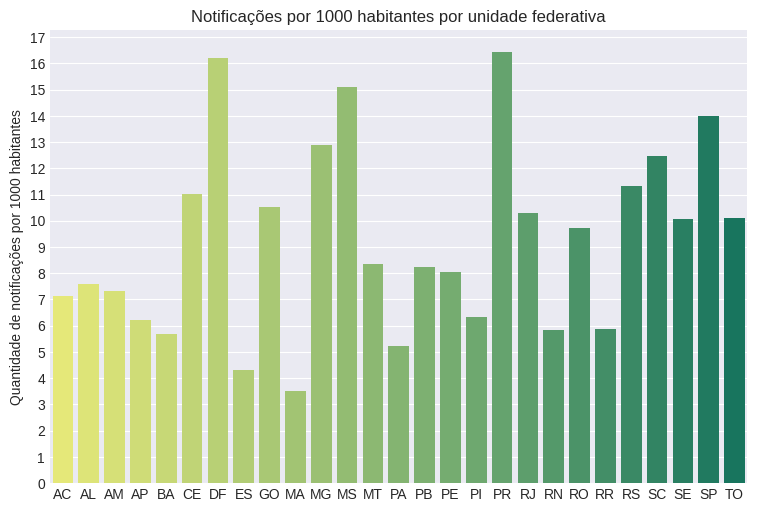

In [38]:
sns.barplot(data=df_populacao, x='UF', y='NotPor1000Hab', palette=PALETA)

plt.title('Notificações por 1000 habitantes por unidade federativa')
plt.xlabel('')
plt.ylabel('Quantidade de notificações por 1000 habitantes')

plt.yticks(range(int(np.ceil(df_populacao['NotPor1000Hab'].max() + 1))));

## Evoluções por 1000 habitantes por unidade federativa

In [39]:
df_evolucao = df[['SG_UF_NOT', 'EVOLUCAO']][df['EVOLUCAO'].isin([1, 2, 3])].value_counts().sort_index().reset_index()
df_evolucao.columns = ['UF', 'Evolucao', 'Quantidade']
df_evolucao['Por1000Hab'] = None

for _, uf in df_populacao.iterrows():
    for i, ev in df_evolucao[df_evolucao['UF'] == uf['UF']].iterrows():
        df_evolucao.loc[i, 'Por1000Hab'] = ev['Quantidade'] / (uf['Populacao'] / 1000)

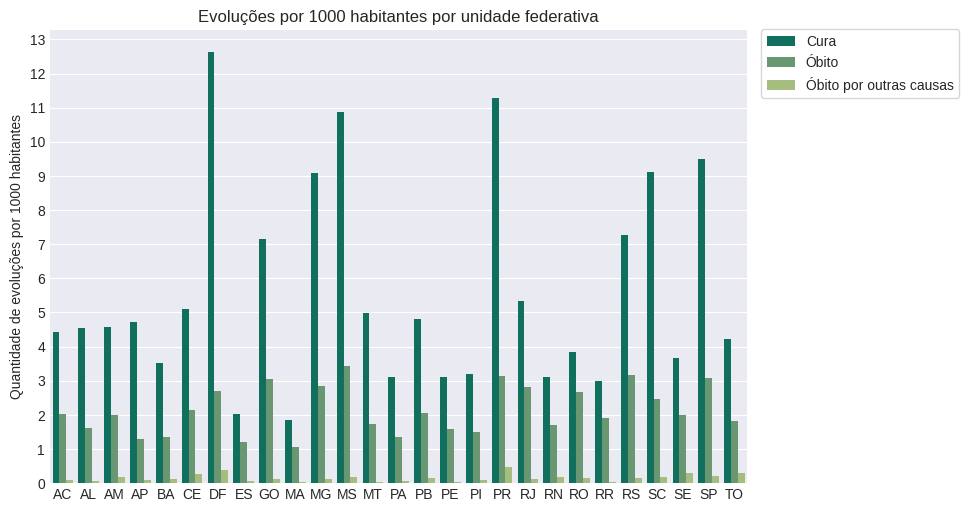

In [40]:
ax = sns.barplot(data=df_evolucao, x='UF', y='Por1000Hab', hue='Evolucao', palette=CORES)

plt.title('Evoluções por 1000 habitantes por unidade federativa')
plt.xlabel('')
plt.ylabel('Quantidade de evoluções por 1000 habitantes')

plt.yticks(range(int(np.ceil(df_evolucao['Por1000Hab'].max() + 1))))

# sns.barplot tem um bug onde a legenda perde as cores se handles e labels não forem informados juntos.
handles, _ = ax.get_legend_handles_labels()

plt.legend(loc=(1.02, 0.85), frameon=True, facecolor='white', handles=handles, labels=EVOLUCOES.values());

## Óbitos por COVID-19 por 1000 habitantes por unidade federativa

In [74]:
df_obitos_covid = df[['SG_UF_NOT']][(df['EVOLUCAO'] == 2) & (df['CLASSI_FIN'] == 5)].value_counts().sort_index().reset_index()
df_obitos_covid.columns = ['UF', 'Quantidade']
df_obitos_covid['Por1000Hab'] = None

for _, uf in df_populacao.iterrows():
    for i, oc in df_obitos_covid[df_obitos_covid['UF'] == uf['UF']].iterrows():
        df_obitos_covid.loc[i, 'Por1000Hab'] = oc['Quantidade'] / (uf['Populacao'] / 1000)

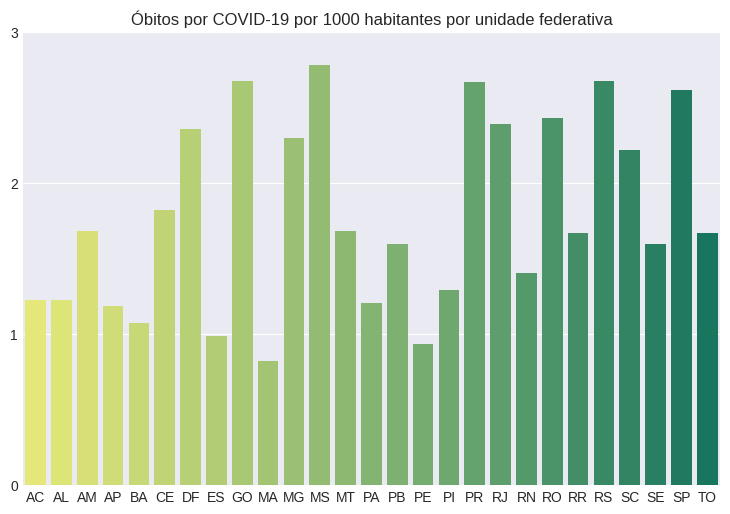

In [82]:
sns.barplot(data=df_obitos_covid, x='UF', y='Por1000Hab', palette=PALETA)

plt.title('Óbitos por COVID-19 por 1000 habitantes por unidade federativa')
plt.xlabel('')
plt.ylabel('')

plt.yticks(range(int(np.ceil(df_obitos_covid['Por1000Hab'].max() + 1))));

## Diagnósticos finais por evolução

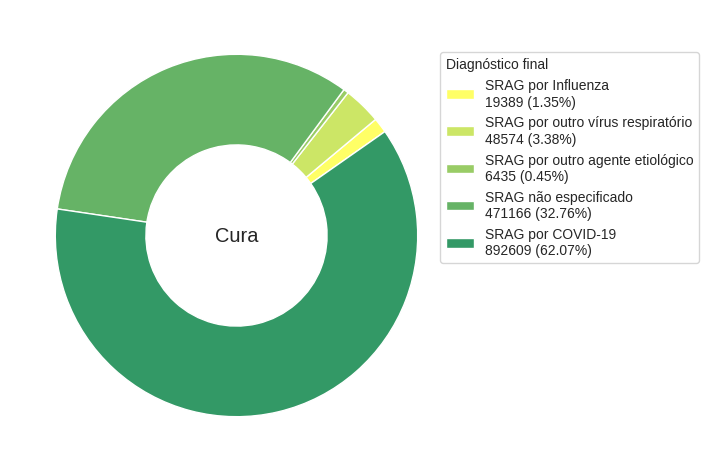

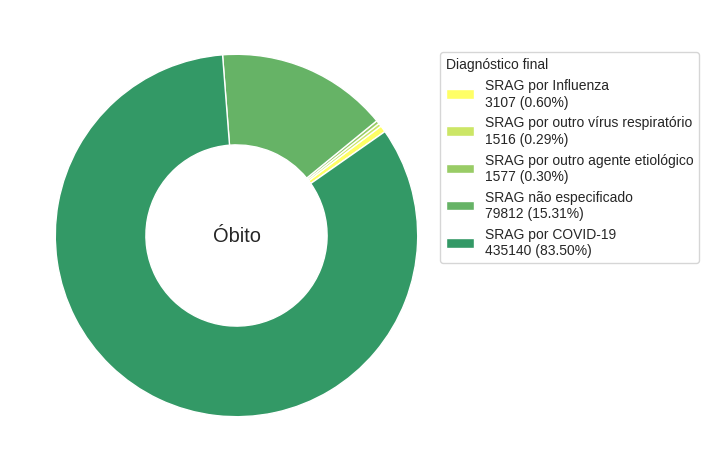

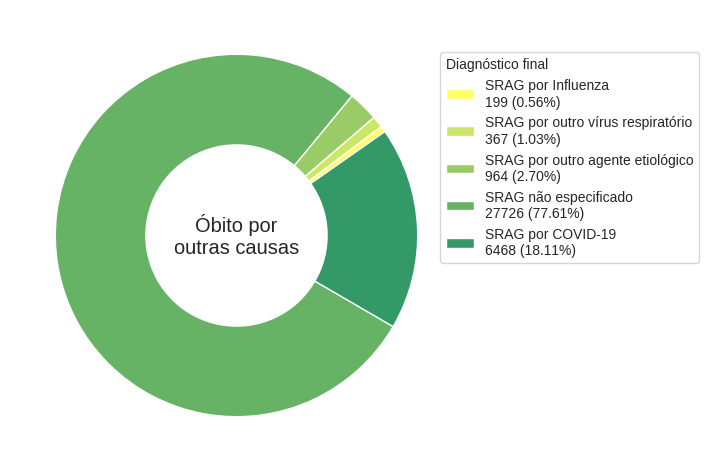

In [41]:
for ev_cod, ev_desc in EVOLUCOES.items():

    dados    = df['CLASSI_FIN'][df['EVOLUCAO'] == ev_cod].value_counts().sort_index().to_list()
    rotulos  = [f'{di}\n{da} ({((da / sum(dados)) * 100):0.2f}%)' for di, da in zip(DIAGNOSTICOS.values(), dados)]
    evolucao = ev_desc if (len(ev_desc.split()) == 1) else ('\n'.join([' '.join(m) for m in np.array_split(ev_desc.split(), 2)]))

    fig, ax = plt.subplots()

    ax.set_prop_cycle('color', [plt.get_cmap(PALETA)(1. * i / len(dados)) for i in range(len(dados))])
    ax.pie(dados, wedgeprops={'width': 0.5, 'edgecolor': 'w'}, startangle=35)
    ax.text(0, 0, evolucao, ha='center', va='center', fontsize='x-large')

    legenda = ax.legend(loc=(0.95, 0.44), frameon=True, facecolor='white', title='Diagnóstico final', labels=rotulos)
    legenda._legend_box.align = 'left'

    plt.show()

## Notificações por unidade federativa por sexo

In [42]:
df_populacao['NotMasculino'] = df['SG_UF_NOT'][df['CS_SEXO'] == 1].value_counts().sort_index().to_list()
df_populacao['NotFeminino']  = df['SG_UF_NOT'][df['CS_SEXO'] == 2].value_counts().sort_index().to_list()

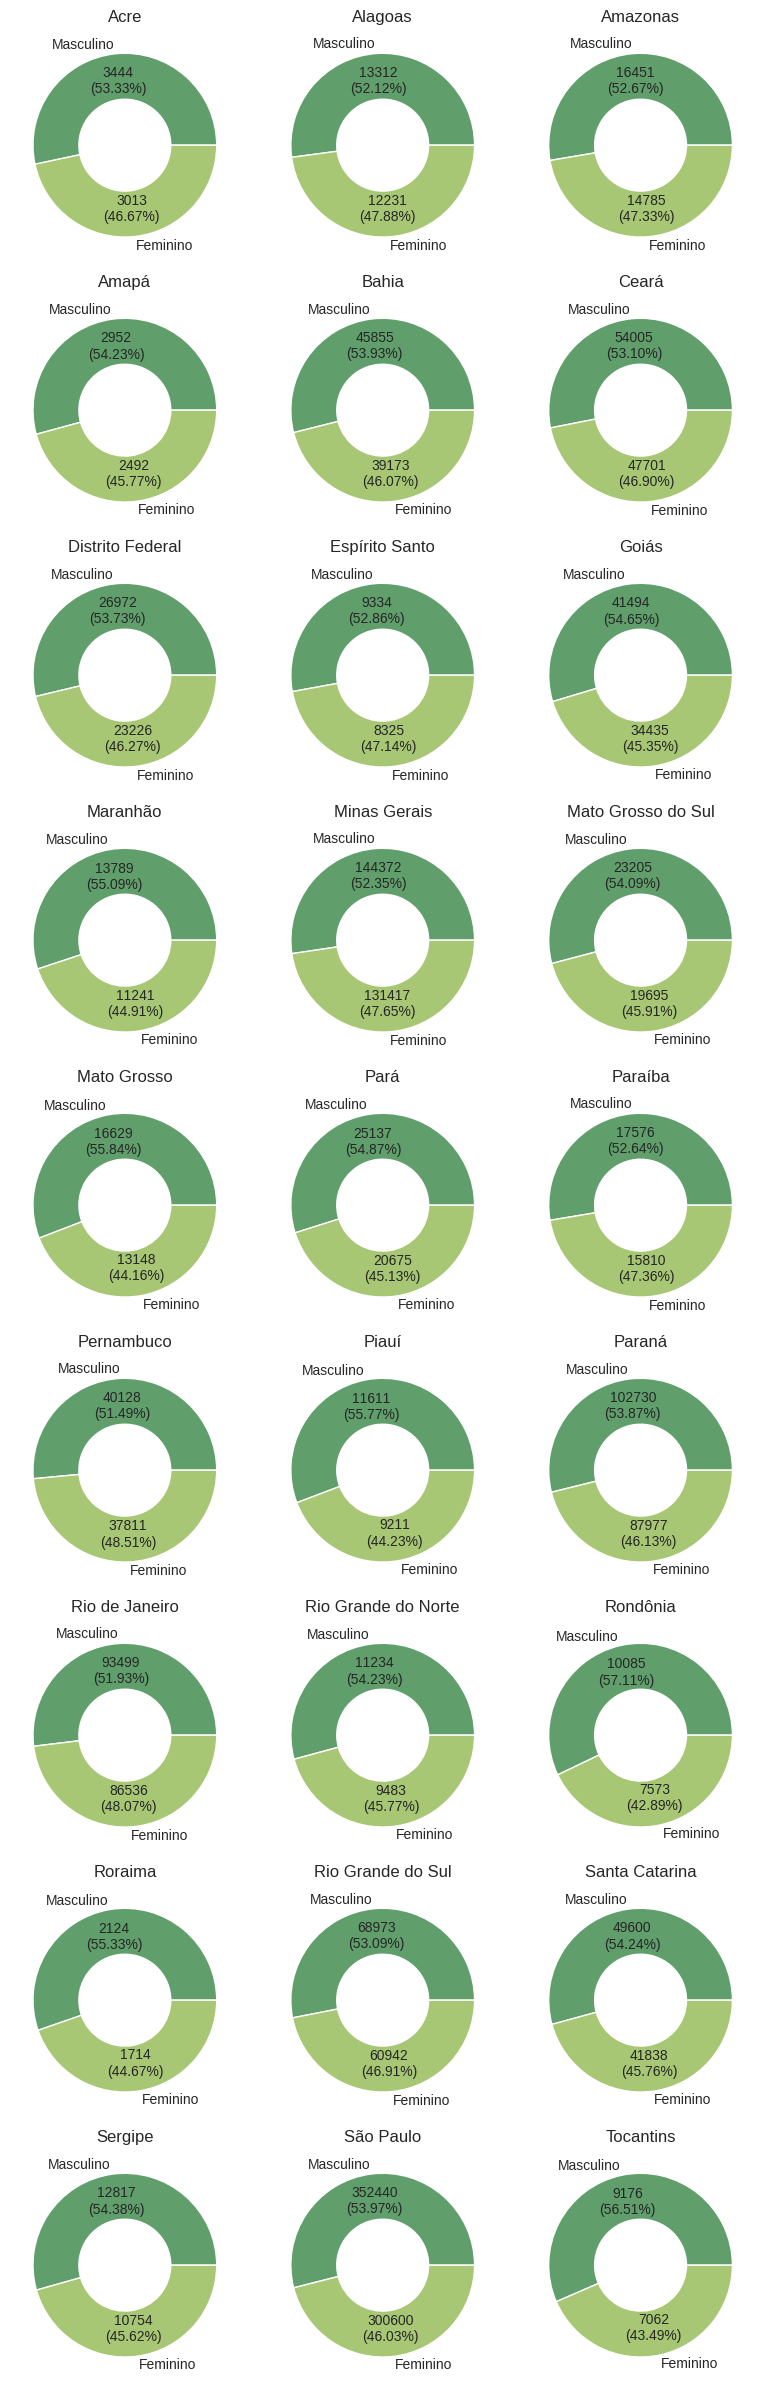

In [43]:
colunas = 3
linhas  = int(np.ceil(len(df_populacao) / colunas))

fig, ax = plt.subplots(linhas, colunas, figsize=[8, 24])

def func(pct, dados):
    return f"{int(pct / 100 * np.sum(dados))}\n({pct:0.2f}%)"

for i, uf in df_populacao.iterrows():

    dados = uf[['NotMasculino', 'NotFeminino']]

    ax[i // colunas, i % colunas].pie(dados,
                                      labels=SEXOS.values(),
                                      autopct=lambda pct: func(pct, dados),
                                      pctdistance=0.7,
                                      wedgeprops={'width': 0.5,
                                                  'edgecolor': 'w'},
                                      colors=CORES[1:])

    ax[i // colunas, i % colunas].set_title(uf['Nome'])

plt.tight_layout()

## Diferença média de dias entre primeiros sintomas e notificação

In [44]:
df_demora = df[['DT_SIN_PRI', 'DT_NOTIFIC']].sort_values(by=['DT_SIN_PRI', 'DT_NOTIFIC']).copy().reset_index(drop=True)
df_demora['Dias'] = ((df_demora['DT_NOTIFIC'] - df_demora['DT_SIN_PRI']) / np.timedelta64(1, 'D')).astype(int)
df_demora.drop(['DT_NOTIFIC'], axis=1, inplace=True)
df_demora = df_demora.groupby(by=['DT_SIN_PRI']).mean().reset_index()

for i, de in df_demora.iterrows():
    df_demora.loc[i, 'Segunda-feira'] = de['DT_SIN_PRI'] - np.timedelta64(de['DT_SIN_PRI'].dayofweek, 'D')

df_demora.drop(['DT_SIN_PRI'], axis=1, inplace=True)
df_demora = df_demora.groupby(by=['Segunda-feira']).mean().reset_index()

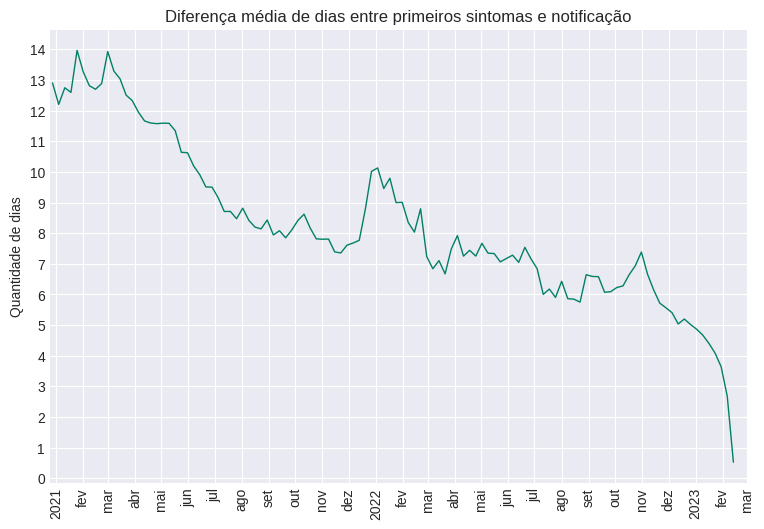

In [45]:
ax = sns.lineplot(data=df_demora, x='Segunda-feira', y='Dias', linewidth=1, color=CORES[0])

plt.title('Diferença média de dias entre primeiros sintomas e notificação')
plt.xlabel('')
plt.ylabel('Quantidade de dias')

plt.xlim([datetime.date(2020, 12, 25), datetime.date(2023, 3, 1)])

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

for tick in ax.get_xticklabels(which='both'):
    tick.set_rotation(90)

plt.yticks(range(int(np.ceil(df_demora['Dias'].max() + 1))))

plt.grid(visible=True, which='both', axis='both');

## Evoluções por semana de primeiros sintomas

In [46]:
df_evolucao = df[['DT_SIN_PRI', 'EVOLUCAO']][df['EVOLUCAO'].isin([1, 2, 3])].value_counts().sort_index().reset_index()
df_evolucao.columns = ['Data', 'Evolucao', 'Quantidade']

for i, ev in df_evolucao.iterrows():
    df_evolucao.loc[i, 'Segunda-feira'] = ev['Data'] - np.timedelta64(ev['Data'].dayofweek, 'D')

df_evolucao = df_evolucao[['Segunda-feira', 'Evolucao', 'Quantidade']].groupby(by=['Segunda-feira', 'Evolucao']).sum().sort_index().reset_index()

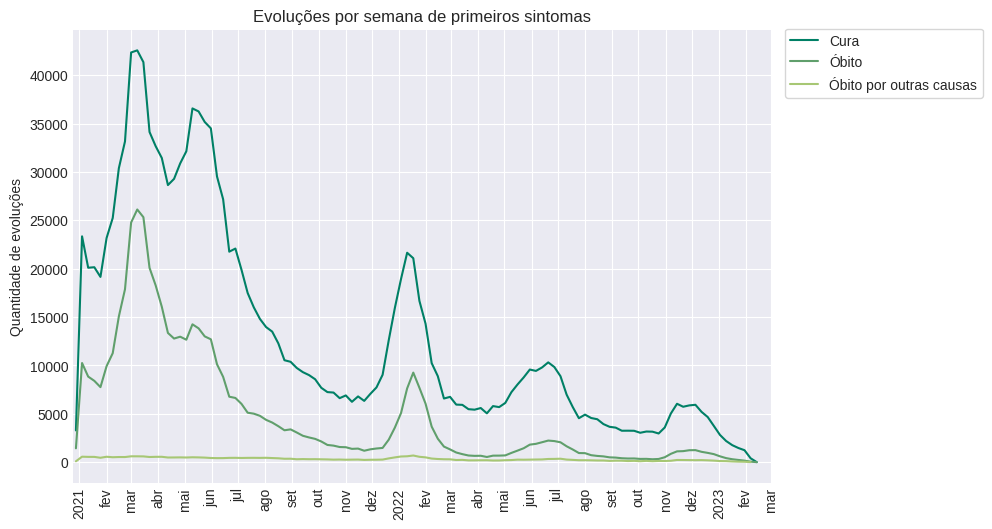

In [47]:
ax = sns.lineplot(data=df_evolucao, x='Segunda-feira', y='Quantidade', hue='Evolucao', palette=CORES[:len(df_evolucao.columns)])

plt.title('Evoluções por semana de primeiros sintomas')
plt.xlabel('')
plt.ylabel('Quantidade de evoluções')

plt.xlim([datetime.date(2020, 12, 25), datetime.date(2023, 3, 1)])

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

for tick in ax.get_xticklabels(which='both'):
    tick.set_rotation(90)

ytick_step = 5000

plt.yticks(np.arange(0, int(np.ceil(df_evolucao['Quantidade'].max() / ytick_step) * ytick_step), ytick_step))

plt.grid(visible=True, which='both', axis='both')

plt.legend(loc=(1.02, 0.85), frameon=True, facecolor='white', labels=EVOLUCOES.values());

## Média de dias hospitalizado ou internado em UTI

In [48]:
# Pacientes que foram internados em UTI mas é ignorado se foram hospitalizados.

df[['HOSPITAL', 'UTI']][(df['UTI'] == 1) & (df['HOSPITAL'] != 1)].value_counts()

HOSPITAL  UTI
9         1      5089
dtype: int64

In [49]:
# Hospitalizados com data de internação e data de evolução (alta ou óbito).
df_internacao = df[['DT_NOTIFIC', 'DT_INTERNA', 'DT_EVOLUCA']][(df['HOSPITAL'] == 1) & (~df['DT_INTERNA'].isna()) & (~df['DT_EVOLUCA'].isna())].sort_values(by=['DT_NOTIFIC', 'DT_INTERNA', 'DT_EVOLUCA']).copy().reset_index(drop=True)

# Quantidade de dias hospitalizado. É adicionado um dia, pois tanto o dia de internação quanto o dia de evolução devem ser considerados.
df_internacao['Dias'] = (((df_internacao['DT_EVOLUCA'] - df_internacao['DT_INTERNA']) / np.timedelta64(1, 'D')) + 1).astype(int)

df_internacao.drop(['DT_INTERNA', 'DT_EVOLUCA'], axis=1, inplace=True)
df_internacao = df_internacao.groupby(by=['DT_NOTIFIC']).mean().reset_index()

for i, ho in df_internacao.iterrows():
    df_internacao.loc[i, 'Segunda-feira'] = ho['DT_NOTIFIC'] - np.timedelta64(ho['DT_NOTIFIC'].dayofweek, 'D')

df_internacao.drop(['DT_NOTIFIC'], axis=1, inplace=True)
df_internacao = df_internacao.groupby(by=['Segunda-feira']).mean().reset_index()

In [50]:
# Internados em UTI com data de entrada e data de saída.
df_uti = df[['DT_NOTIFIC', 'DT_ENTUTI', 'DT_SAIDUTI']][(df['HOSPITAL'] == 1) & (~df['DT_ENTUTI'].isna()) & (~df['DT_SAIDUTI'].isna())].sort_values(by=['DT_NOTIFIC', 'DT_ENTUTI', 'DT_SAIDUTI']).copy().reset_index(drop=True)

# Quantidade de dias internado. É adicionado um dia, pois tanto o dia de entrada quanto o dia de saída devem ser considerados.
df_uti['Dias'] = (((df_uti['DT_SAIDUTI'] - df_uti['DT_ENTUTI']) / np.timedelta64(1, 'D')) + 1).astype(int)

df_uti.drop(['DT_ENTUTI', 'DT_SAIDUTI'], axis=1, inplace=True)
df_uti = df_uti.groupby(by=['DT_NOTIFIC']).mean().reset_index()

for i, ho in df_uti.iterrows():
    df_uti.loc[i, 'Segunda-feira'] = ho['DT_NOTIFIC'] - np.timedelta64(ho['DT_NOTIFIC'].dayofweek, 'D')

df_uti.drop(['DT_NOTIFIC'], axis=1, inplace=True)
df_uti = df_uti.groupby(by=['Segunda-feira']).mean().reset_index()

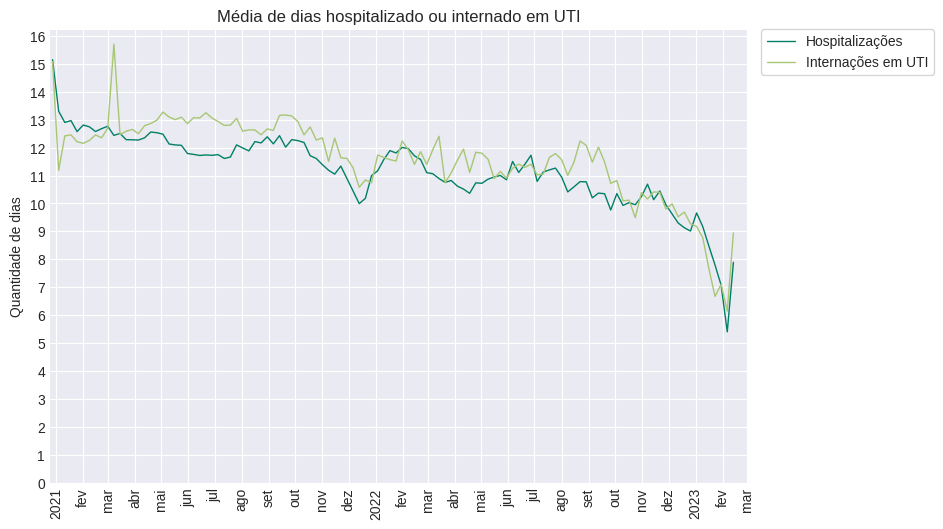

In [51]:
ax = sns.lineplot(data=df_internacao, x='Segunda-feira', y='Dias', linewidth=1, color=CORES[0], label='Hospitalizações')
sns.lineplot(data=df_uti, x='Segunda-feira', y='Dias', linewidth=1, color=CORES[2], label='Internações em UTI')

plt.title('Média de dias hospitalizado ou internado em UTI')
plt.xlabel('')
plt.ylabel('Quantidade de dias')

plt.xlim([datetime.date(2020, 12, 25), datetime.date(2023, 3, 1)])

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

for tick in ax.get_xticklabels(which='both'):
    tick.set_rotation(90)

# plt.yticks(range(int(np.floor(min(df_internacao['Dias'].min(), df_uti['Dias'].min()) - 1)),
#                  int(np.ceil(max(df_internacao['Dias'].max(), df_uti['Dias'].max()) + 1))))

plt.yticks(range(int(np.ceil(max(df_internacao['Dias'].max(), df_uti['Dias'].max()) + 1))))

plt.grid(visible=True, which='both', axis='both')

plt.legend(loc=(1.02, 0.9), frameon=True, facecolor='white');

## Correlações entre sintomas

In [52]:
campos  = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'OUTRO_SIN']
filtros = [df[c].isin([1, 2]) for c in campos]  # Lista de filtros.
filtro  = np.vstack(filtros).all(axis=0)        # Combina os resultados dos filtros em um único array.

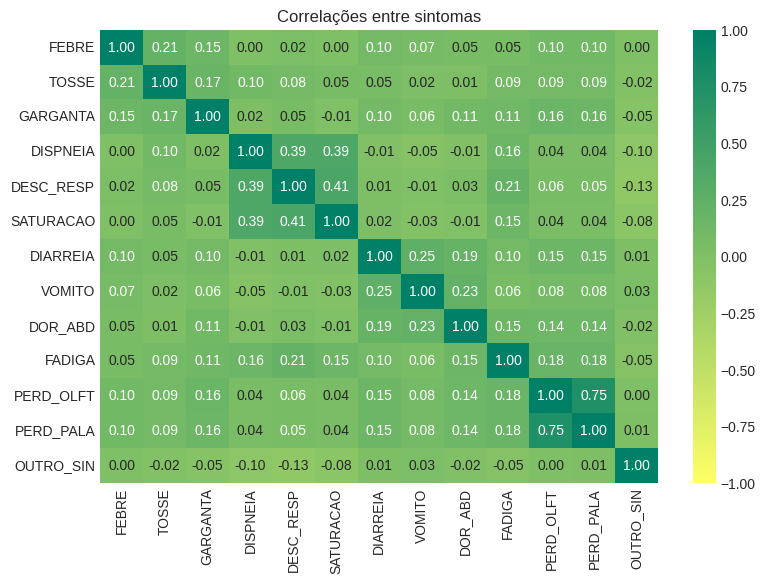

In [53]:
sns.heatmap(data=df[campos][filtro].corr(), annot=True, fmt="0.2f", vmin=-1, vmax=1, cmap=PALETA)

plt.title('Correlações entre sintomas');

## Anotações

In [54]:
# Evolução do caso.
# 1 - Cura
# 2 - Óbito
# 3 - Óbito por outras causas
# 9 - Ignorado

df['EVOLUCAO'].value_counts(dropna=False).sort_index()

1      1438173
2       521152
3        35724
9       282791
NaN          0
Name: EVOLUCAO, dtype: Int64

In [55]:
# CLASSI_FIN
# 1 - SRAG por influenza
# 2 - SRAG por outro vírus respiratório
# 3 - SRAG por outro agente etiológico, qual:
# 4 - SRAG não especificado
# 5 - SRAG por covid-19

df['CLASSI_FIN'].value_counts(dropna=False).sort_index()

1        25840
2        53460
3         9792
4       756668
5      1432080
NaN          0
Name: CLASSI_FIN, dtype: Int64

In [56]:
# CS_RACA
# 1 - Branca
# 2 - Preta
# 3 - Amarela
# 4 - Parda
# 5 - Indígena
# 9 - Ignorado

df['CS_RACA'].value_counts(dropna=False).sort_index()

1      958000
2       93459
3       20073
4      810643
5        4284
9      391381
NaN         0
Name: CS_RACA, dtype: Int64

In [57]:
# CS_ESCOL_N
# 0 - Sem escolaridade / Analfabeto
# 1 - Fundamental 1º ciclo (1ª a 5ª série)
# 2 - Fundamental 2º ciclo (6ª a 9ª série)
# 3 - Médio (1º ao 3º ano)
# 4 - Superior
# 5 - Não se aplica
# 9 - Ignorado

df['CS_ESCOL_N'].value_counts(dropna=False).sort_index()

0        80068
1       204309
2       129121
3       205697
4        85071
5        97892
9      1475682
NaN          0
Name: CS_ESCOL_N, dtype: Int64

In [58]:
# CS_ZONA
# 1 - Urbana
# 2 - Rural
# 3 - Periurbana
# 9 - Ignorado

df['CS_ZONA'].value_counts(dropna=False).sort_index()

1      1873947
2       113835
3        11363
9       278695
NaN          0
Name: CS_ZONA, dtype: Int64

In [59]:
# PCR_RESUL
# 1 - Detectável
# 2 - Não detectável
# 3 - Inconclusivo
# 4 - Não realizado
# 5 - Aguardando resultado
# 9 - Ignorado

df['PCR_RESUL'].value_counts(dropna=False).sort_index()

1      932142
2      523253
3        4037
4      221199
5      337159
9      260050
NaN         0
Name: PCR_RESUL, dtype: Int64

In [60]:
# RES_AN
# 1 - Positivo
# 2 - Negativo
# 3 - Inconclusivo
# 4 - Não realizado
# 5 - Aguardando resultado
# 9 - Ignorado

df['RES_AN'].value_counts(dropna=False).sort_index()

1      414000
2      190225
3         307
4      418919
5      925238
9      329151
NaN         0
Name: RES_AN, dtype: Int64

In [61]:
with pd.option_context('display.max_seq_items', None):
    display(df.columns)

Index(['DT_NOTIFIC', 'SEM_NOT', 'DT_SIN_PRI', 'SEM_PRI', 'SG_UF_NOT',
       'CO_REGIONA', 'CO_MUN_NOT', 'CO_UNI_NOT', 'CS_SEXO', 'DT_NASC',
       'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'SG_UF', 'CO_RG_RESI',
       'CO_MUN_RES', 'CS_ZONA', 'NOSOCOMIAL', 'AVE_SUINO', 'FEBRE', 'TOSSE',
       'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO',
       'OUTRO_SIN', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI',
       'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OBES_IMC', 'OUT_MORBI', 'VACINA',
       'DT_UT_DOSE', 'MAE_VAC', 'DT_VAC_MAE', 'M_AMAMENTA', 'DT_DOSEUNI',
       'DT_1_DOSE', 'DT_2_DOSE', 'ANTIVIRAL', 'TP_ANTIVIR', 'DT_ANTIVIR',
       'HOSPITAL', 'DT_INTERNA', 'SG_UF_INTE', 'CO_RG_INTE', 'CO_MU_INTE',
       'UTI', 'DT_ENTUTI', 'DT_SAIDUTI', 'SUPORT_VEN', 'RAIOX_RES', 'DT_RAIOX',
       'AMOSTRA', 'DT_COLETA', 'TP_AMOSTRA', 'PCR_RESUL', 'DT_PCR',
       'POS_PCRFLU', 'TP_FLU_PC

In [62]:
df['NOSOCOMIAL'].value_counts(dropna=False).sort_index()

1        45052
2      1705660
9       527128
NaN          0
Name: NOSOCOMIAL, dtype: Int64

In [63]:
df['AVE_SUINO'].value_counts(dropna=False).sort_index()

1        19895
2      1516907
3         2004
9       739034
NaN          0
Name: AVE_SUINO, dtype: Int64

In [64]:
df['ANTIVIRAL'].value_counts(dropna=False).sort_index()

1        68915
2      1470185
9       738740
NaN          0
Name: ANTIVIRAL, dtype: Int64

In [65]:
df['TRAT_COV'].value_counts(dropna=False).sort_index()

1         2882
2        76870
9      2198088
NaN          0
Name: TRAT_COV, dtype: Int64

# Aprendizado

## Regressão sobre sintomas e fatores de risco, com EVOLUCAO como atributo alvo

In [66]:
campos  = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT',
           'PERD_PALA', 'OUTRO_SIN', 'FATOR_RISC', 'PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES',
           'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI', 'EVOLUCAO']

filtros = [df[c].isin([1, 2]) for c in campos]  # Lista de filtros.
filtro  = np.vstack(filtros).all(axis=0)        # Combina os resultados dos filtros em um único array.

In [67]:
X = df[campos][filtro].replace({2: 0}).astype('int')

y = X['EVOLUCAO']
X = X.drop('EVOLUCAO', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

In [68]:
# # Rabalancear dados de treino aumentando a amostragem da classe menor.

# treino = pd.concat([X_train, y_train], axis=1)

# obito = treino[treino['EVOLUCAO'] == 0]
# cura  = treino[treino['EVOLUCAO'] == 1]

# obito = resample(obito, replace=True, n_samples=len(cura), random_state=SEMENTE)

# treino = pd.concat([obito, cura])

# y_train = treino['EVOLUCAO']
# X_train = treino.drop('EVOLUCAO', axis=1)

In [69]:
%%time

modelo = DecisionTreeClassifier(random_state=SEMENTE)

modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

# param_grid = {'criterion': ['gini', 'entropy'],
#               'splitter': ['best', 'random'],
#               'max_features': ['sqrt', 'log2', None],
#               'random_state': [SEMENTE]}

# grid = GridSearchCV(estimator=modelo,
#                     param_grid=param_grid,
#                     scoring='f1_weighted',
#                     cv=10,
#                     verbose=1)

# grid.fit(X_train, y_train)

# print(grid.best_params_)

# y_pred = grid.predict(X_test)

CPU times: user 4.06 s, sys: 9.43 ms, total: 4.07 s
Wall time: 5.52 s


              precision    recall  f1-score   support

           0       0.43      0.21      0.28     16796
           1       0.70      0.88      0.78     36185

    accuracy                           0.66     52981
   macro avg       0.57      0.54      0.53     52981
weighted avg       0.62      0.66      0.62     52981



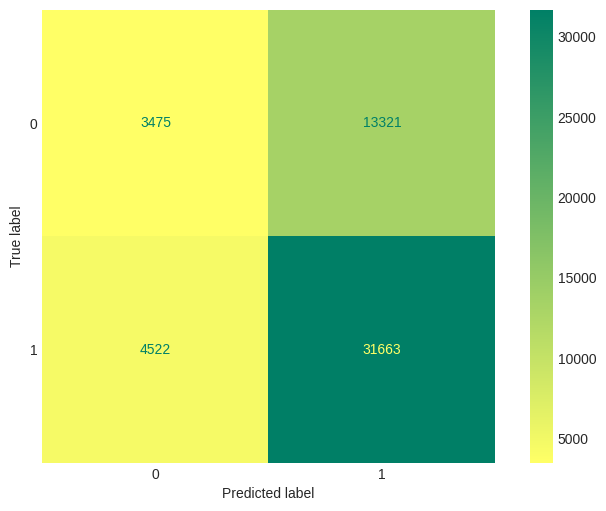

In [70]:
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='d', cmap=PALETA)
plt.grid(False)